<a href="https://colab.research.google.com/github/btnwilson/TSCSeizureClassification/blob/main/Seizure_Classification_Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Performing Saliency Analysis On Models Trained for Seizure Classification

In an attempt to better grasp what the models trained to classify seizure or no seizure saliency analysis can be used to see which portion of a signal has a significant impact on the final classification value. Below is code that reloads the best trained models and providing them sample inputs that are analysed and saliency scores are provided for each input value/region.

In [ ]:
# install specific packages needed for analysis not native to colab
!pip install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.8 MB/s eta 0:00:00


In [ ]:
# import other dependencies and mount google drive to access stored files
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as F
import os
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from google.colab import drive
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.decomposition import PCA
import joblib
import itertools

drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Deep Learning Final Project")

Mounted at /content/drive


##Load and process data for sample files

In [ ]:
#Load data from npz file stored in drive and extract raw data and labels
all_raw_data = np.load("DeepLearningSeizureData.npz")
raw_data = all_raw_data["data"]
raw_labels = all_raw_data["labels"]

In [ ]:
#Load the pca weights and components used to train the models to allow for the application
# of the same transformation with use of test data
model_pca = joblib.load('pca_model.pkl')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
#Extract 5 samples from each class
res = RandomUnderSampler(sampling_strategy={0: 5, 1: 5}, random_state=10)
data_resampled, labels_resampled = res.fit_resample(raw_data, raw_labels)
print(f"Shape of data: {data_resampled.shape}")
print(f"Shape of labels: {labels_resampled.shape}")
print(f"Number of Seizures: {np.sum(labels_resampled)}")

Shape of data: (10, 3840)
Shape of labels: (10,)
Number of Seizures: 5


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [ ]:
#transform that sampled data using PCA
transformed_data = model_pca.transform(data_resampled)

In [ ]:
# define the class used to store the data. Class is passed to pytorch dataloader class
class EEGDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]
        return sample, label

In [ ]:
#Create data loader for each type of data raw and transformed
data_loader = DataLoader(EEGDataset(data_resampled, labels_resampled), batch_size=5, shuffle=False, num_workers=2)
transformed_data_loader = DataLoader(EEGDataset(transformed_data, labels_resampled), batch_size=5, shuffle=False, num_workers=2)

In [ ]:
#Define function to produce a saliency map
def saliency_map(model, input_data, target_class=None):
    # Ensure input requires gradients
    input_data.requires_grad_()

    # Forward pass
    output = model(input_data)

    # Determine the class score to use for saliency computation
    if output.shape[1] == 1:  # Single-logit (binary classification)
        class_score = output[0]  # Use the single output directly
    else:  # Multi-class case
        if target_class is None:
            raise ValueError("target_class must be specified for multi-class models.")
        class_score = output[0, target_class]

    # Backpropagate to get gradients
    model.zero_grad()
    class_score.backward()

    # Get the saliency (absolute value of the gradient)
    saliency = input_data.grad.abs().squeeze()

    # Check the shape of saliency
    print(f"Saliency shape: {saliency.shape}")

    # Create time array for plot
    time_axis = np.arange(0, len(saliency)) / 128

    # Plot the saliency above the data input
    plt.figure(figsize=(10, 5))
    # Plot the saliency map
    plt.subplot(2, 1, 1)
    plt.plot(time_axis, saliency.cpu().detach().numpy(), label='Saliency', color='red')
    plt.title("Saliency Map")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Saliency Value")
    plt.legend()
    # Plot the input data
    plt.subplot(2, 1, 2)
    plt.plot(time_axis, input_data.squeeze().cpu().detach().numpy(), label='Input Data', color='blue')
    plt.title("Input Data")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()



##Load Two Sample Inputs

Label: 0


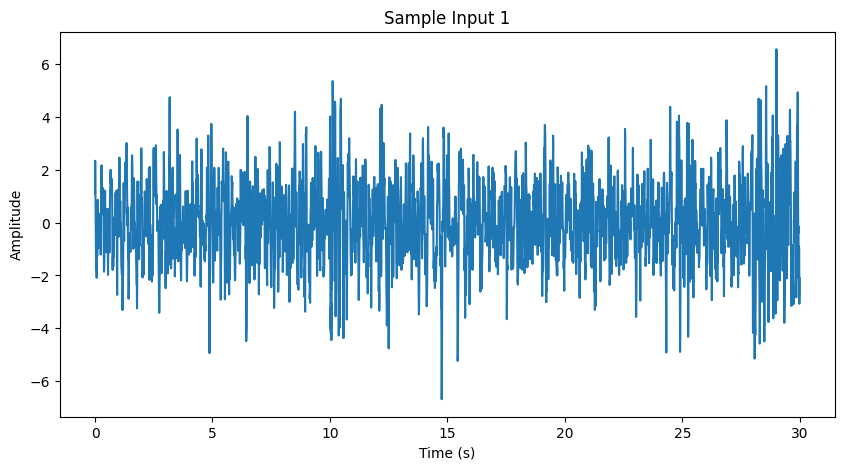

In [ ]:
# load the fist batch which is size 5 all of class 0
sample_input, label = next(iter(data_loader))
sample_input_neg_1 = sample_input[0]
label_neg_1 = label[0]

#Check size of sample
print(f"Label: {label_neg_1.item()}")
#Visualize sample
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, 30, 1/128), sample_input_neg_1)
plt.title("Sample Input 1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


Label: 1


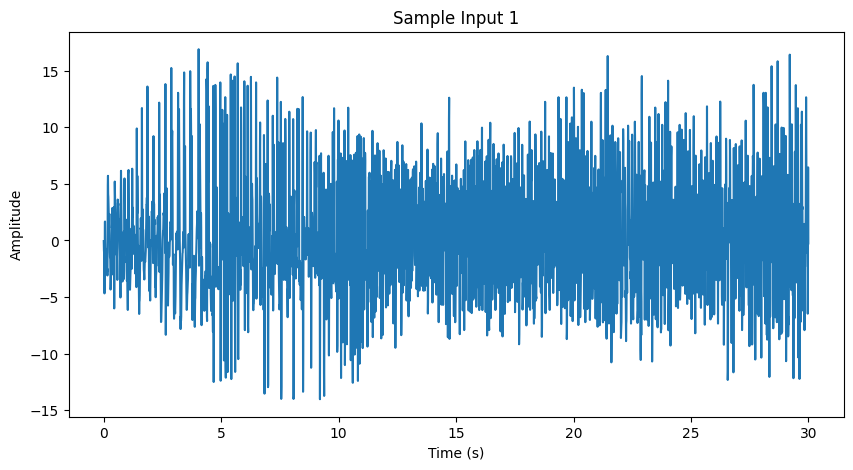

In [ ]:
# Get the second batch
second_batch = next(itertools.islice(data_loader, 1, 2))
sample_input, label = second_batch

# Extract a sample from the class 1 batch of timeseries data
sample_input_pos_1 = sample_input[0]
label_pos_1 = label[0]

#Check sample size and plot seizure clip
print(f"Label: {label_pos_1.item()}")
plt.figure(figsize=(10,5))
plt.plot(np.arange(0, 30, 1/128), sample_input_pos_1)
plt.title("Sample Input 1")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

##Analysis of first simple CNN trained using an unweighted loss function

In [ ]:
#Define class that describes model architechure
class EEGCNN1D(nn.Module):
    # Constructor
    def __init__(self):
        super(EEGCNN1D, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 4th Convolutional Block
        self.conv4 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (3840 // 16), 128)  # Adjust based on sequence_length
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    # Method to complete a forward pass
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
#Load model to processor and apply weights from model save
torch.cuda.empty_cache()
simple_cnn = EEGCNN1D()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_cnn.to(device)
best_model_path = f"CNN1_best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

<ipython-input-14-123ed2b59895>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


EEGCNN1D(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): ReLU()
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

torch.Size([3840])
Saliency shape: torch.Size([3840])


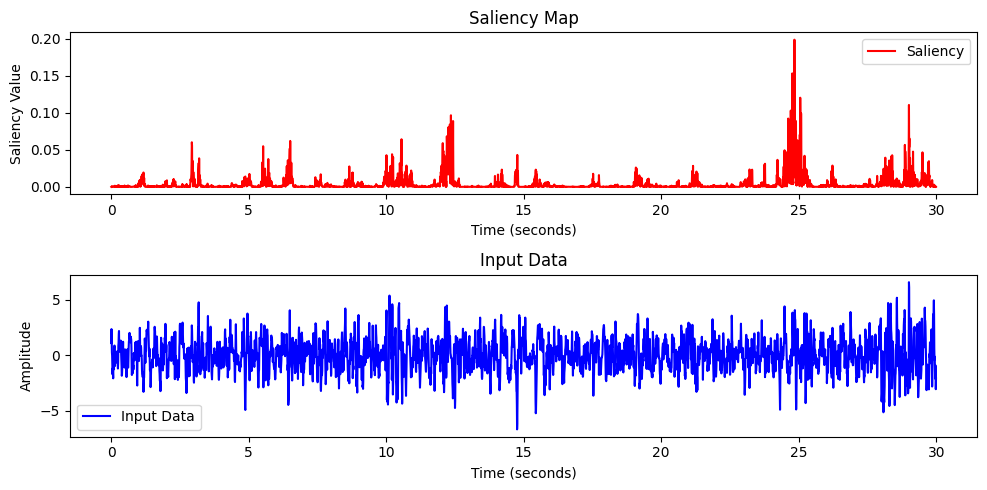

In [ ]:
#Perform saliency analysis on class 0 sample
sample_input_neg_1 = sample_input_neg_1.to(device)
print(sample_input_neg_1.shape)
saliency_map(model, sample_input_neg_1.unsqueeze(0).unsqueeze(0), target_class=0)

torch.Size([3840])
Saliency shape: torch.Size([3840])


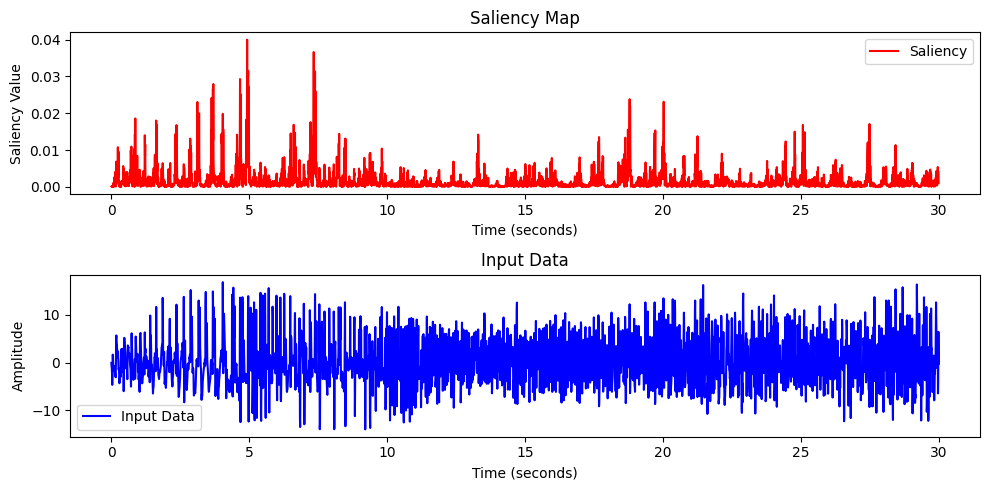

In [ ]:
#Perform saliency analysis on class 1 sample
sample_input_pos_1 = sample_input_pos_1.to(device)
print(sample_input_pos_1.shape)
saliency_map(model, sample_input_pos_1.unsqueeze(0).unsqueeze(0), target_class=1)

##Evaluate second model of same structure but trained using a weighted loss function to address class size disparity seen in dataset

In [ ]:
#Load model and saved training weights
torch.cuda.empty_cache()
simple_cnn = EEGCNN1D()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_cnn.to(device)
best_model_path = f"CNN1Weighted_best_model.pth"
model.load_state_dict(torch.load(best_model_path))
model.eval()

<ipython-input-17-eb5a7dd27893>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


EEGCNN1D(
  (conv1): Conv1d(1, 16, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu1): ReLU()
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu2): ReLU()
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu3): ReLU()
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
  (relu4): ReLU()
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (relu_fc1): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

torch.Size([3840])
Saliency shape: torch.Size([3840])


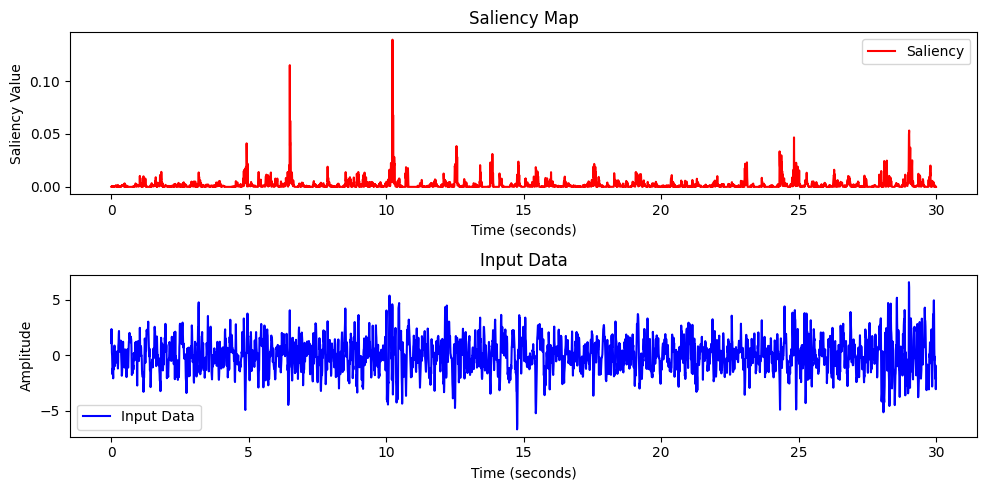

In [ ]:
#Perform saliency analysis on class 0 sample
sample_input_neg_1 = sample_input_neg_1.to(device)
print(sample_input_neg_1.shape)
saliency_map(model, sample_input_neg_1.unsqueeze(0).unsqueeze(0), target_class=0)

torch.Size([3840])
Saliency shape: torch.Size([3840])


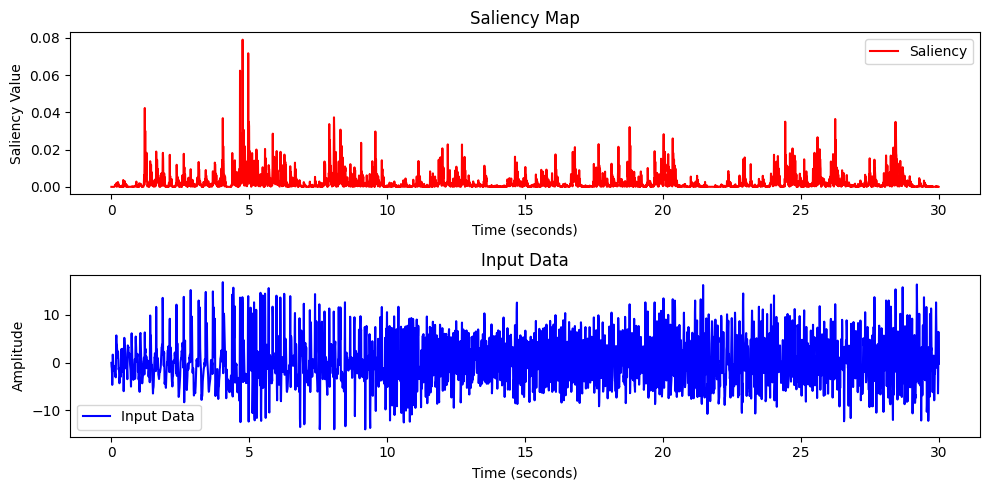

In [ ]:
#Perform saliency analysis on class 1 sample
sample_input_pos_1 = sample_input_pos_1.to(device)
print(sample_input_pos_1.shape)
saliency_map(model, sample_input_pos_1.unsqueeze(0).unsqueeze(0), target_class=1)

##Reload samples but for data the was transformed by PCA

In [ ]:
#Get first batch of transformed data loader
sample_input, label = next(iter(transformed_data_loader))
#Extract a class 0 sample and examine its label
sample_input_neg_1 = sample_input[0]
label_neg_1 = label[0]
print(f"Label: {label_neg_1.item()}")

Label: 0


In [ ]:
#Move on to the second batch of class 1 examples
second_batch = next(itertools.islice(transformed_data_loader, 1, 2))
sample_input, label = second_batch
#Get class 1 sample and check label
sample_input_pos_1 = sample_input[0]
label_pos_1 = label[0]
print(f"Label: {label_pos_1.item()}")
print(sample_input_pos_1.shape)

Label: 1
torch.Size([1024])


In [ ]:
# Redifine saliency map function for data in PCA space
def saliency_map_PCA(model, input_data, pca, target_class=None):
    # Ensure input requires gradients
    input_data.requires_grad_()

    # Forward pass
    output = model(input_data)

    # Determine the class score to use for saliency computation
    if output.shape[1] == 1:  # Single-logit (binary classification)
        class_score = output[0]  # Use the single output directly
    else:  # Multi-class case
        if target_class is None:
            raise ValueError("target_class must be specified for multi-class models.")
        class_score = output[0, target_class]  # Use the specific target class index

    # Backpropagate to get gradients
    model.zero_grad()
    class_score.backward()

    # Get the saliency (absolute value of the gradient)
    saliency = input_data.grad.abs().squeeze()  # Remove batch and channel dimensions

    # Check the shape of saliency
    print(f"Saliency shape: {saliency.shape}")

    # Ensure time axis matches the data length
    time_axis = np.arange(0, 30, 1/128)  # Assuming 128 Hz sampling rate

    eeg = pca.inverse_transform(input_data.squeeze().cpu().detach().numpy())
    saliency_time_domain = pca.inverse_transform(saliency.cpu().detach().numpy())
    # Plot the saliency map as a 1D signal
    plt.figure(figsize=(12, 10))

    # Plot the saliency map
    plt.subplot(4, 1, 1)
    plt.plot(np.arange(0, 1024),saliency.cpu().detach().numpy(), label='Saliency', color='red')
    plt.title("Saliency Map")
    plt.xlabel("Principal Component")
    plt.ylabel("Saliency Value")
    plt.legend()

    # Plot the input data
    plt.subplot(4, 1, 2)
    plt.scatter(np.arange(0, 1024), input_data.squeeze().cpu().detach().numpy(), label='Input Data', color='blue')
    plt.title("Input Data")
    plt.xlabel("Principal Component")
    plt.ylabel("PCA Value")
    plt.legend()

    # Plot the input data
    plt.subplot(4, 1, 3)
    plt.plot(time_axis, np.abs(saliency_time_domain), label='EEG Data', color='red')
    plt.title("Saliency Time Domain")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Saliency Value")
    plt.legend()


    # Plot the input data
    plt.subplot(4, 1, 4)
    plt.plot(time_axis, eeg, label='EEG Data', color='blue')
    plt.title("EEG Data")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.tight_layout()
    plt.show()

##Analyze LSTM Model

In [ ]:
# define model architecure used for LSTM network previously trained
class EEGLSTM(nn.Module):
    #constructor
    def __init__(self):
        super(EEGLSTM, self).__init__()
        self.hidden_size = 64
        self.num_layers = 1
        self.dropout = nn.Dropout(p=0.3)
        #LSTM block
        self.lstm = nn.LSTM(1024, self.hidden_size, self.num_layers, batch_first=True)

        # Fully connected output
        self.fc = nn.Linear(self.hidden_size, 1)

    #Method to perform forward pass
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the LSTM output
        out = self.fc(out)
        return out

In [ ]:
#Initialize model and apply weights saved from training
torch.cuda.empty_cache()
simple_cnn = EEGLSTM()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_cnn.to(device)
best_model_path = f"LSTMWeighted_best_model.pth"
model.load_state_dict(torch.load(best_model_path))

<ipython-input-24-8a3f71ccab5e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

torch.Size([1024])
Saliency shape: torch.Size([1024])


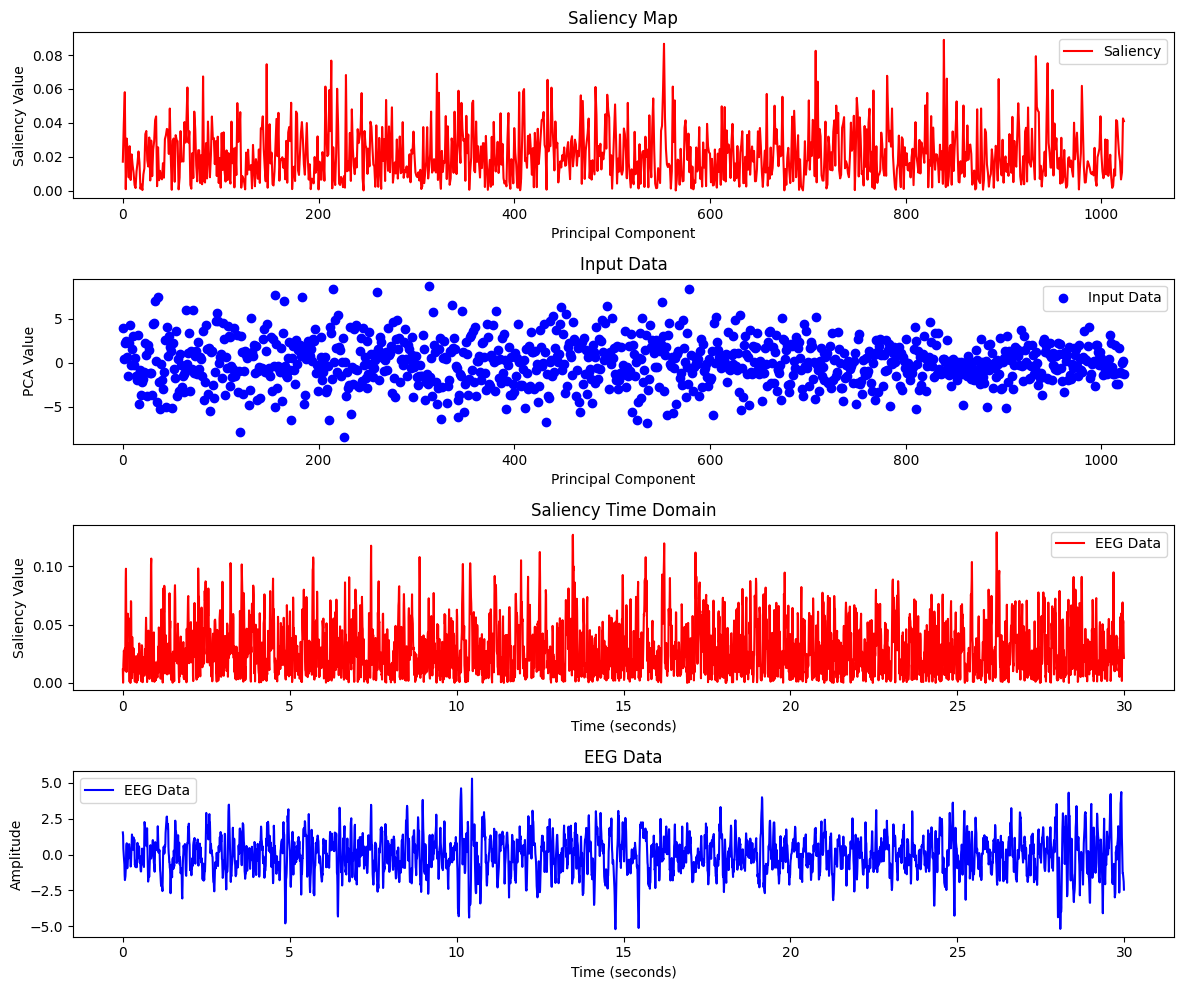

In [ ]:
#Perform saliency analysis on class 0 sample
sample_input_neg_1 = sample_input_neg_1.to(device)
print(sample_input_neg_1.shape)
saliency_map_PCA(model, sample_input_neg_1.unsqueeze(0).unsqueeze(0), model_pca, target_class=0)

torch.Size([1024])
Saliency shape: torch.Size([1024])


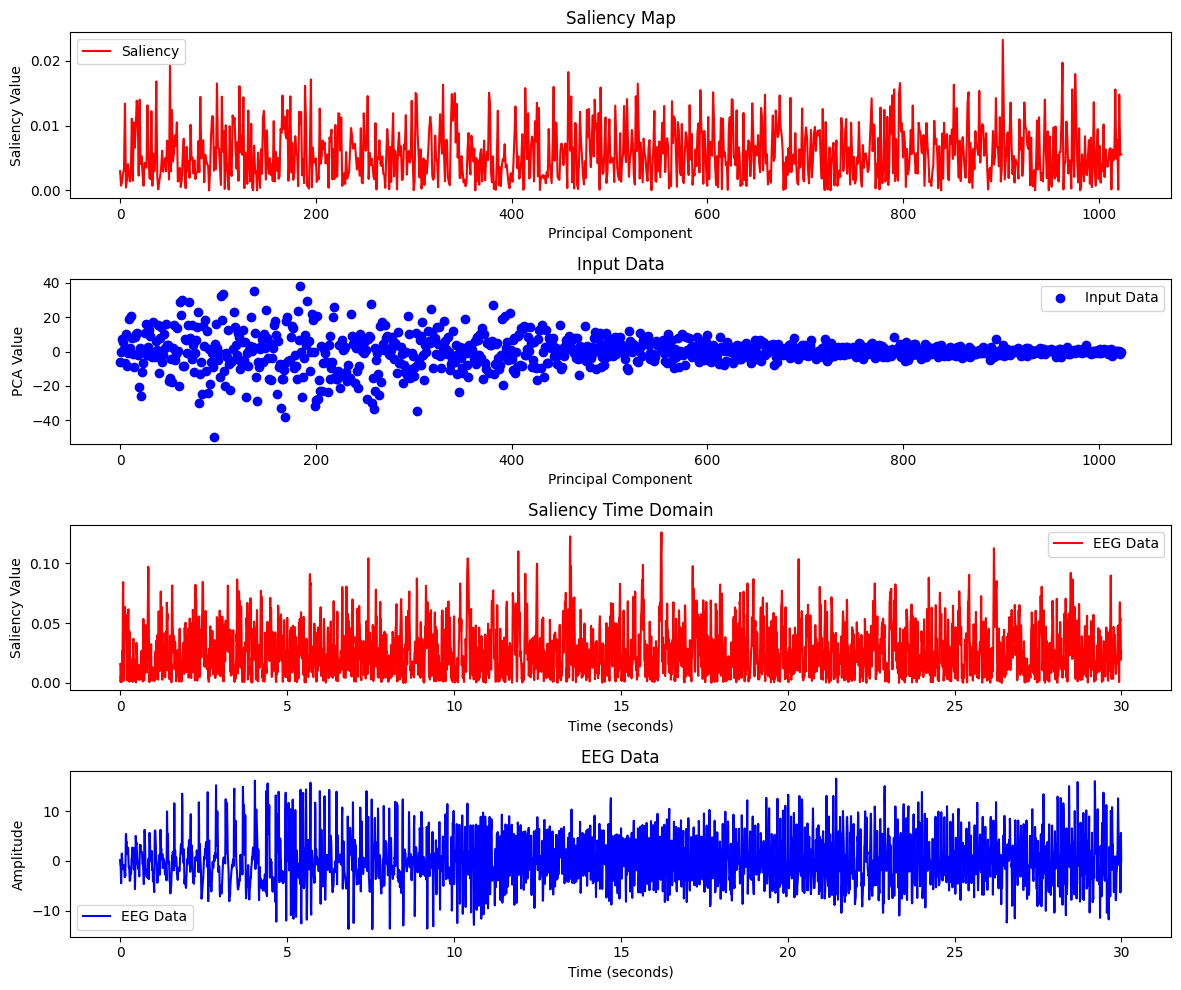

In [ ]:
#Perform saliency analysis on class 1 sample
sample_input_pos_1 = sample_input_pos_1.to(device)
print(sample_input_pos_1.shape)
saliency_map_PCA(model, sample_input_pos_1.unsqueeze(0).unsqueeze(0), model_pca,target_class=1)

##Perform analysis on Transformer model

In [ ]:
#Define transformer architecture
class EEGTRANSFORMER(nn.Module):
    # Constructor
    def __init__(self):
        super(EEGTRANSFORMER, self).__init__()
        dim_model = 1024
        num_heads = 4

        encoder_layer = nn.TransformerEncoderLayer(dim_model, num_heads, dim_feedforward=4*dim_model, activation = "relu", dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2, norm=nn.LayerNorm(dim_model))
        self.fc = nn.Linear(dim_model, 1)

    #method for forward pass
    def forward(self, x):
        x = self.transformer_encoder(x)
        x = torch.mean(x, dim=1)
        x = self.fc(x)
        return x

In [ ]:
#Initialize model and load training weights
torch.cuda.empty_cache()
simple_cnn = EEGTRANSFORMER()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_cnn.to(device)
best_model_path = f"TransformerWeighted_best_model.pth"
model.load_state_dict(torch.load(best_model_path))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-28-1e8e2ebee4ea>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

<All keys matched successfully>

torch.Size([1024])
Saliency shape: torch.Size([1024])


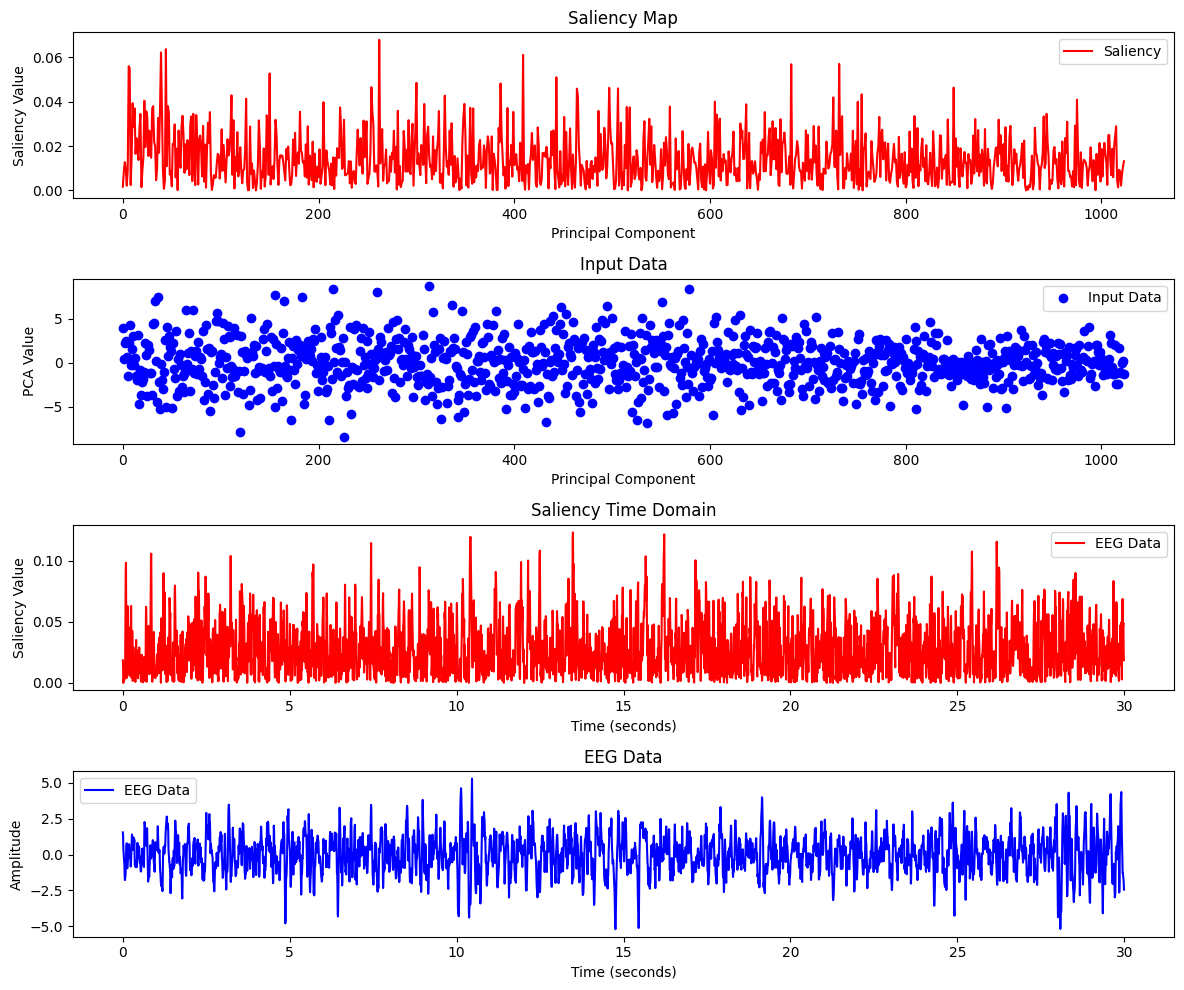

In [ ]:
#Perform saliency analysis on class 0 sample
sample_input_neg_1 = sample_input_neg_1.to(device)
print(sample_input_neg_1.shape)
saliency_map_PCA(model, sample_input_neg_1.unsqueeze(0).unsqueeze(0), model_pca, target_class=0)

torch.Size([1024])
Saliency shape: torch.Size([1024])


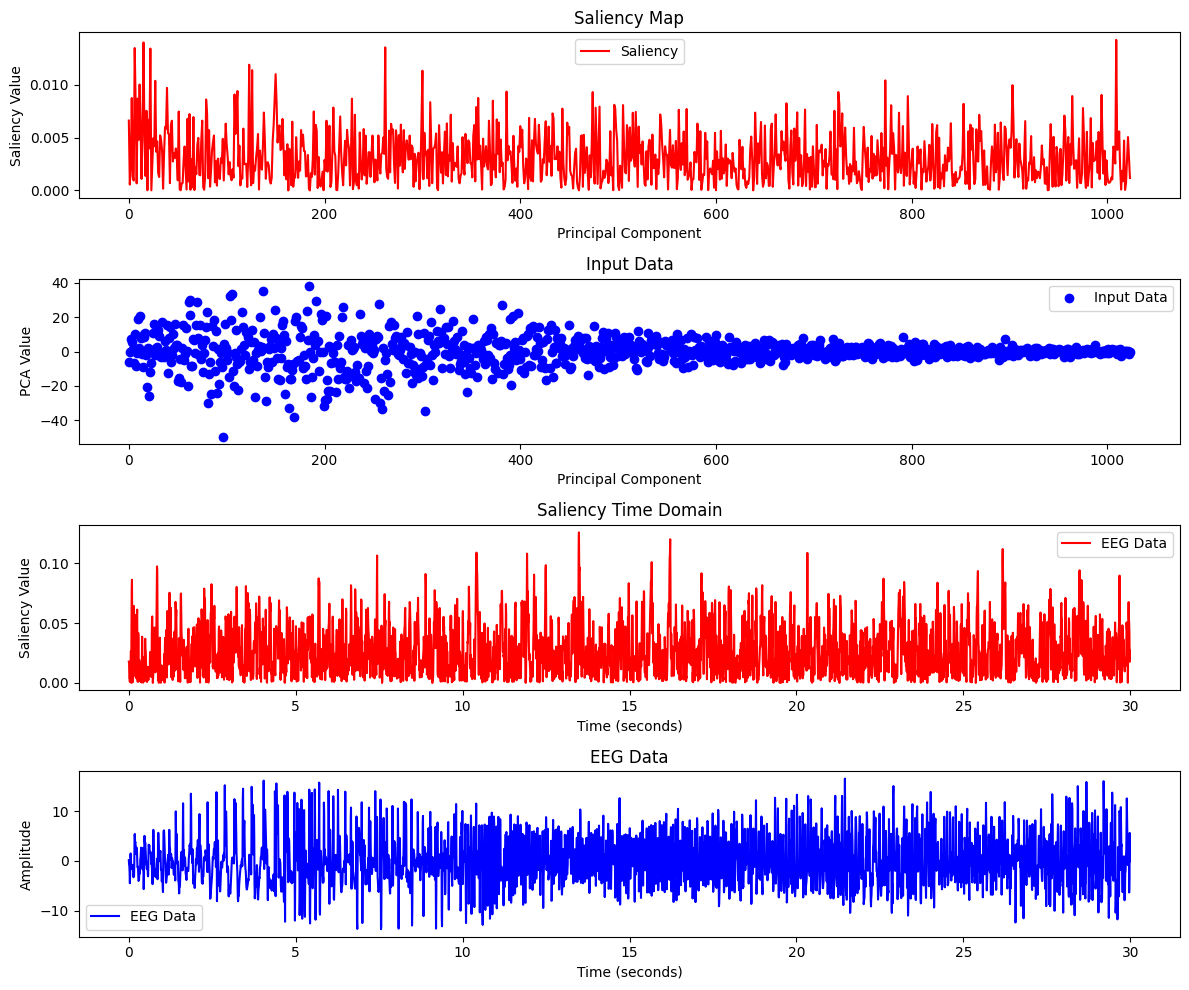

In [ ]:
#Perform saliency analysis on class 1 sample
sample_input_pos_1 = sample_input_pos_1.to(device)
print(sample_input_pos_1.shape)
saliency_map_PCA(model, sample_input_pos_1.unsqueeze(0).unsqueeze(0), model_pca,target_class=1)

##Perform saliency on CNN trained using PCA transform data

In [ ]:
class EEGCNNPCA1D(nn.Module):
    #Constuctor
    def __init__(self):
        super(EEGCNNPCA1D, self).__init__()

        # 1st Convolutional Block
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 2nd Convolutional Block
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        # 3rd Convolutional Block
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * (1024 // 8), 128)  # Adjust based on sequence_length
        self.relu_fc1 = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)

    #Method to perform forward pass
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu_fc1(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
#Initialize and load training weights of model
torch.cuda.empty_cache()
simple_cnn = EEGCNNPCA1D()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = simple_cnn.to(device)
best_model_path = f"CNN1ModifiedData_best_model.pth"
model.load_state_dict(torch.load(best_model_path))

<ipython-input-32-338f26a1ce75>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

torch.Size([1024])
Saliency shape: torch.Size([1024])


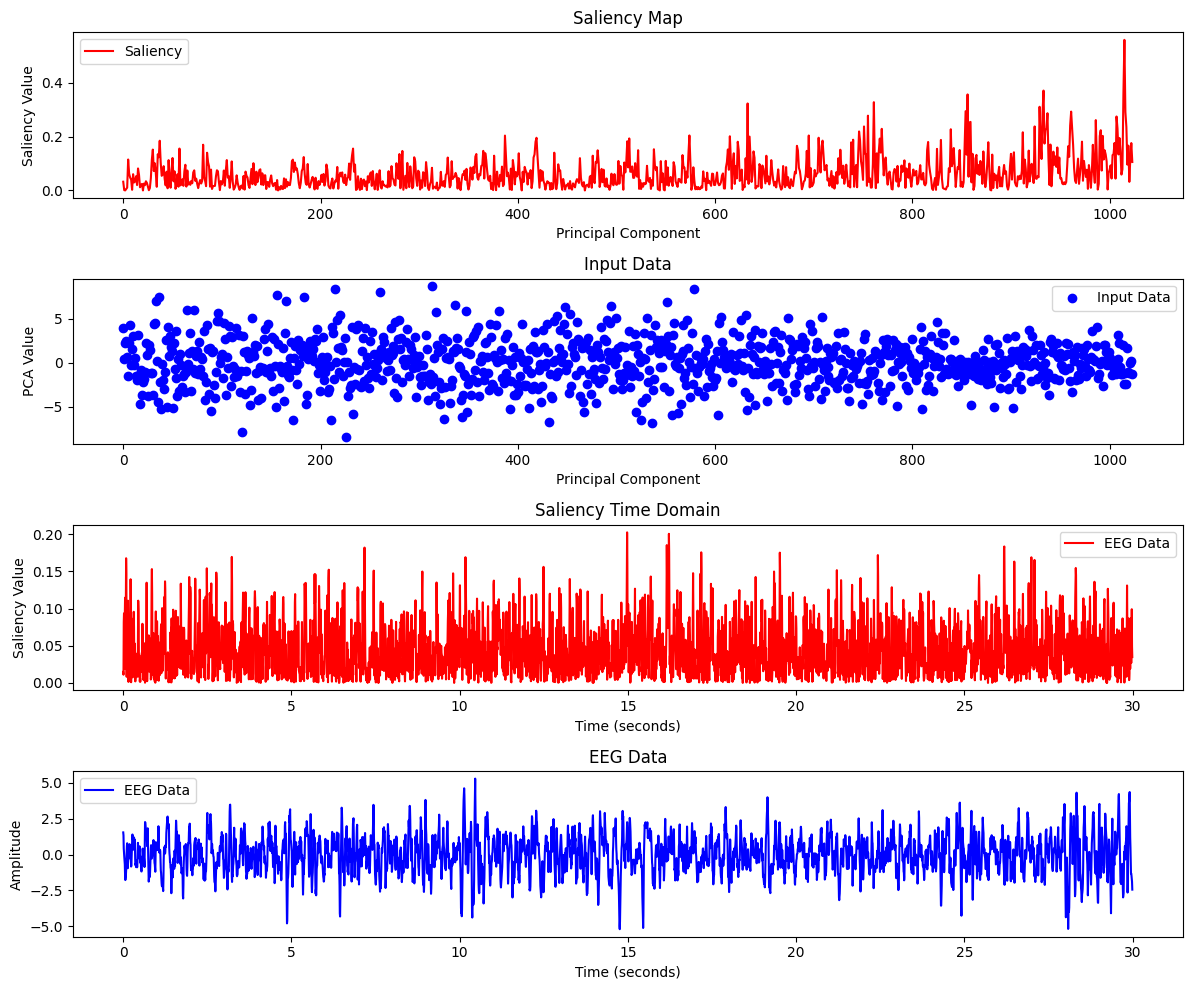

In [ ]:
#Perform saliency analysis on class 0 sample
sample_input_neg_1 = sample_input_neg_1.to(device)
print(sample_input_neg_1.shape)
saliency_map_PCA(model, sample_input_neg_1.unsqueeze(0).unsqueeze(0), model_pca, target_class=0)

torch.Size([1024])
Saliency shape: torch.Size([1024])


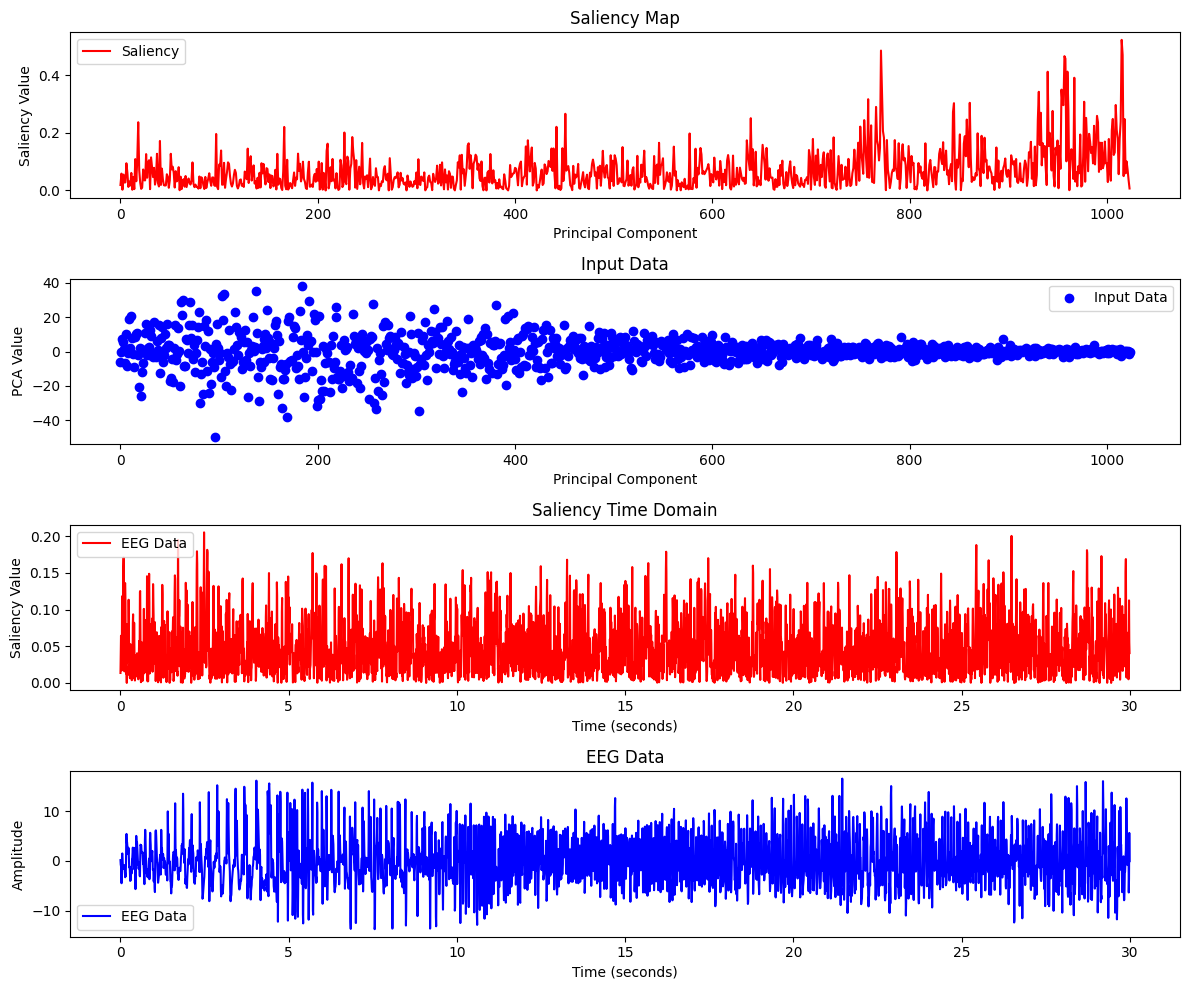

In [ ]:
#Perform saliency analysis on class 1 sample
sample_input_pos_1 = sample_input_pos_1.to(device)
print(sample_input_pos_1.shape)
saliency_map_PCA(model, sample_input_pos_1.unsqueeze(0).unsqueeze(0), model_pca,target_class=1)